
Please check the instruction again on how to read Edge List and construct a DIRECTED graph.
The default one is UNDIRECTED graph.
You have to use add "create_using=nx.DiGraph" for NetworkX to construct a directed one.

Instead of adjacency matrix, we will use Edge List as the input:
https://networkx.github.io/documentation/stable/reference/readwrite/edgelist.html



In [19]:
import networkx as nx
import time

In [20]:
G = nx.Graph()
G = nx.read_edgelist("inputfile.edgelist", create_using=nx.DiGraph())

NameError: name 'plt' is not defined

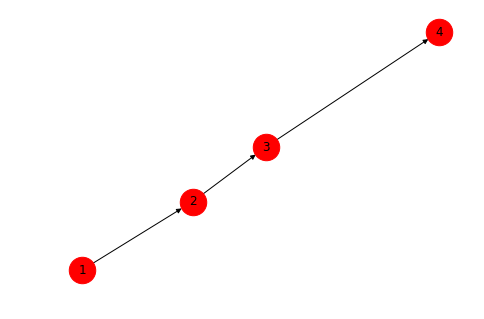

In [21]:
nx.draw(G, with_labels=True, node_size=700, front_size=12)
plt.show()

Implement the BFS we learned in class (Note1). In your code, you need to add
comments to indicate which line of your code corresponds to a particular line of
pseudo-code presented in Note1.

In [25]:
def bfs(G, u):
    visted = [] # line1: array Visted[1...n] 
    #Becuase visited this is empty,it also covers # line2: Initialize: Set visted[i] = FALSE for 1 <= i <= n
    toExplore=[] #line3: List: ToExplore, S
    s = [] #line3: List: ToExplore, S
    toExplore.append(u) #line4: Add u to ToExplore and to S, Visted[u]=True
    s.append(u) #line4: Add u to ToExplore and to S, Visted[u]=True
    visted.append(u) #line4: Add u to ToExplore and to S, Visted[u]=True
    #line5: Make tree T with root as u
    while toExplore: 
        x = toExplore.pop(0) #line7: Remove node x from ToExplore
        for y in G[x]: #line8: for each edge (x,y) in Adj(x) do
            if y not in visted: #line9: if (Visted[y] == False)
                visted.append(y)
                toExplore.append(y)
                s.append(y)
    return s
            

The build_residual_network method is code directly taken from documentation: https://networkx.github.io/documentation/networkx-1.10/_modules/networkx/algorithms/flow/utils.html#build_residual_network

We used this as a guide for writing out own code to build a residual network, but did not call this function.

In [ ]:
def build_residual_network(G, weight):
    """Build a residual network and initialize a zero flow.

    The residual network :samp:`R` from an input graph :samp:`G` has the
    same nodes as :samp:`G`. :samp:`R` is a DiGraph that contains a pair
    of edges :samp:`(u, v)` and :samp:`(v, u)` iff :samp:`(u, v)` is not a
    self-loop, and at least one of :samp:`(u, v)` and :samp:`(v, u)` exists
    in :samp:`G`.

    For each edge :samp:`(u, v)` in :samp:`R`, :samp:`R[u][v]['capacity']`
    is equal to the capacity of :samp:`(u, v)` in :samp:`G` if it exists
    in :samp:`G` or zero otherwise. If the capacity is infinite,
    :samp:`R[u][v]['capacity']` will have a high arbitrary finite value
    that does not affect the solution of the problem. This value is stored in
    :samp:`R.graph['inf']`. For each edge :samp:`(u, v)` in :samp:`R`,
    :samp:`R[u][v]['flow']` represents the flow function of :samp:`(u, v)` and
    satisfies :samp:`R[u][v]['flow'] == -R[v][u]['flow']`.

    The flow value, defined as the total flow into :samp:`t`, the sink, is
    stored in :samp:`R.graph['flow_value']`. If :samp:`cutoff` is not
    specified, reachability to :samp:`t` using only edges :samp:`(u, v)` such
    that :samp:`R[u][v]['flow'] < R[u][v]['capacity']` induces a minimum
    :samp:`s`-:samp:`t` cut.

    """
    capacity = 'weight'
    if G.is_multigraph():
        raise nx.NetworkXError(
            'MultiGraph and MultiDiGraph not supported (yet).')

    R = nx.DiGraph()
    R.add_nodes_from(G)

    inf = float('inf')
    # Extract edges with positive capacities. Self loops excluded.
    edge_list = [(u, v, attr) for u, v, attr in G.edges_iter(data=True)
                 if u != v and attr.get(capacity, inf) > 0]
    # Simulate infinity with three times the sum of the finite edge capacities
    # or any positive value if the sum is zero. This allows the
    # infinite-capacity edges to be distinguished for unboundedness detection
    # and directly participate in residual capacity calculation. If the maximum
    # flow is finite, these edges cannot appear in the minimum cut and thus
    # guarantee correctness. Since the residual capacity of an
    # infinite-capacity edge is always at least 2/3 of inf, while that of an
    # finite-capacity edge is at most 1/3 of inf, if an operation moves more
    # than 1/3 of inf units of flow to t, there must be an infinite-capacity
    # s-t path in G.
    inf = 3 * sum(attr[capacity] for u, v, attr in edge_list
                  if capacity in attr and attr[capacity] != inf) or 1
    if G.is_directed():
        for u, v, attr in edge_list:
            r = min(attr.get(capacity, inf), inf)
            if not R.has_edge(u, v):
                # Both (u, v) and (v, u) must be present in the residual
                # network.
                R.add_edge(u, v, capacity=r)
                R.add_edge(v, u, capacity=0)
            else:
                # The edge (u, v) was added when (v, u) was visited.
                R[u][v]['capacity'] = r
    else:
        for u, v, attr in edge_list:
            # Add a pair of edges with equal residual capacities.
            r = min(attr.get(capacity, inf), inf)
            R.add_edge(u, v, capacity=r)
            R.add_edge(v, u, capacity=r)

    # Record the value simulating infinity.
    R.graph['inf'] = inf

    return R

Implement the iterative version of the Ford-Fulkerson algorithm presented in class. In
your code, you need to add comments to indicate which line of your code corresponds
to a particular line of pseudo-code presented in Note3. In your algorithm, use BFS
implemented in the previous step to find the path in each iteration.

In [47]:
def iterativeFF_bfs(G, s, t):
    #line1: Start with flow f that is 0 on all edges
    f=0
    #Gf= nx.build_residual_network(G, capacity)
    Gf=G.copy()
    path = bfs(Gf,s)
    f_p = float('inf')
    while len(path)>0: #line2: while there is a flow f' in Gf with v(f') > 0 do
        #each time you augment flow
        #fwd add flow going and bkwd edge subtract
        #find f'
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i+1]
            weight = Gf[u][v]['weight']
            f_p = min(f_p, weight)
            
        #line4: Update Gf
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i+1]
            
            #Create a backward edge 
            if not Gf.has_edge(v, u):
                Gf.add_edge(v, u, weight=0)
            old = Gf[v][u]['weight']
            Gf[v][u]['weight'] = old + f_p
            #Create a forward edge 
            old = Gf[u][v]['weight']
            Gf[u][v]['weight'] = old - f_p
            if old == f_p:
                Gf.remove_edge(u, v)
        f = f + f_p #line3: f = f + f'

        try:
            path = bfs(Gf, s)
        except nx.NetworkXNoPath:
            path = []
    return f #line5: Output f

Implement a new version of the max-flow algorithm which replaces BFS by Dijkstra’s
algorithm. You do NOT need to implement Dijkstra. You can directly use NetworkX’s
library.

In [51]:
def iterativeFF_dijkstra(G, s, t):
    #line1: Start with flow f that is 0 on all edges
    f=0
    #Gf= nx.build_residual_network(G, capacity) (
    Gf=G.copy()
    path = nx.dijkstra_path(Gf,s)
    f_p = float('inf')
    while len(path)>0: #line2: while there is a flow f' in Gf with v(f') > 0 do
        #find f'
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i+1]
            weight = Gf[u][v]['weight']
            f_p = min(f_p, weight)
            
        #line4: Update Gf
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i+1]
            
            #Create a backward edge 
            if not Gf.has_edge(v, u):
                Gf.add_edge(v, u, weight=0)
            old = Gf[v][u]['weight']
            Gf[v][u]['weight'] = old + f_p
            #Create a forward edge 
            old = Gf[u][v]['weight']
            Gf[u][v]['weight'] = old - f_p
            if old == f_p:
                Gf.remove_edge(u, v)
        f = f + f_p #line3: f = f + f'

        try:
            path = nx.dijkstra_path(Gf, s)
        except nx.NetworkXNoPath:
            path = []
    return f #line5: Output f

Compare the performance between Ford-Fulkerson + BFS and Ford-Fulkerson +
Dijkstra. Make sure you conduct comprehensive evaluation (e.g., run two algorithms
on a large enough number of random graphs) and present data and your conclusion
clearly and precisely.

In [53]:
def compareTime(G, s, t):
    t1_bfs=time.time()
    iterativeFF_bfs(G, s, t)
    t2_bfs=time.time()
    runtime_bfs= t2_bfs - t1_bfs
    print("The runtime of iterative ford fulkerson with bfs is: ", runtime_bfs)
    
    t1_dijkstra=time.time()
    iterativeFF_dijkstra(G, s, t)
    t2_dijkstra=time.time()
    runtime_dijkstra= t2_dijkstra - t1_dijkstra
    print("The runtime of iterative ford fulkerson with dijkstra is: ", runtime_dijkstra)
    
    if runtime_bfs > runtime_dijkstra:
        print("dijkstra's is faster by: ", abs(runtime_dijkstra-runtime_bfs))
    else:
        print("bfs is faster by: ", abs(runtime_dijkstra-runtime_bfs))
    
    

## We were unable to get our two ford fulkerson algs to run, so we couldn't test the run times. This is the code we would use to test our algs (if they worked)!

2